In [1]:
import os
import sys
sys.path.append("/mnt/home/ubuntu/workspace/code/compositional-representation-learning")

import yaml
import pickle

import numpy as np
import cv2
from torchvision import transforms
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt

from pl_modules import HierarchicalBoxEmbeddingsVAE
from datasets import get_dataset

/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/ubuntu/miniconda3/envs/vh-crl/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened b

In [2]:
config_filepath = "/mnt/home/ubuntu/workspace/code/compositional-representation-learning/configs/HierarchicalBoxEmbeddingsVAE/HierarchicalBoxEmbeddingsVAE_test.yaml"
checkpoint_filepath = "/mnt/home/ubuntu/workspace/experiment_root_dir/HierarchicalBoxEmbeddingsVAE/HierarchicalBoxEmbeddingsVAE_test/HierarchicalBoxEmbeddingsVAE_test___2025-12-25__11-04-06/checkpoints/model-epoch=300.ckpt"

# --- Load Config & Model ---
with open(config_filepath, "r") as file_handle:
    config = yaml.safe_load(file_handle)

model = HierarchicalBoxEmbeddingsVAE.load_from_checkpoint(checkpoint_filepath, config=config)
model.to("cuda")
model.eval()

HierarchicalBoxEmbeddingsVAE(
  (vae): BoxEmbedVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

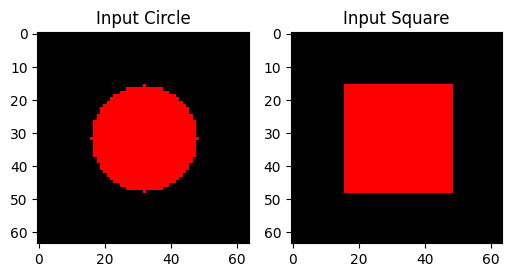

In [3]:
def generate_specific_shape(shape_type, image_size=(64, 64)):
    """Generates a centered red shape."""
    image = np.zeros([image_size[0], image_size[1], 3], dtype=np.uint8)
    
    # Standard Red (BGR in cv2) -> (0, 0, 255)
    color = (255, 0, 0) 
    
    # Fixed center and reasonable size
    center = (image_size[0] // 2, image_size[1] // 2)
    
    if shape_type == "circle":
        radius = image_size[0] // 4
        cv2.circle(image, center, radius, color, -1)
    elif shape_type == "square":
        side_length = image_size[0] // 2
        top_left = (center[0] - side_length // 2, center[1] - side_length // 2)
        bottom_right = (center[0] + side_length // 2, center[1] + side_length // 2)
        cv2.rectangle(image, top_left, bottom_right, color, -1)

    # Transform to Tensor (Matches v0Dataset transform)
    transform = transforms.Compose([transforms.ToTensor()])
    return transform(image)

# Generate and Batch
red_circle = generate_specific_shape("circle").unsqueeze(0) # (1, C, H, W)
red_square = generate_specific_shape("square").unsqueeze(0) # (1, C, H, W)

batch_images = torch.cat([red_circle, red_square], dim=0).to("cuda")

# Quick visualization to verify
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(red_circle.squeeze().permute(1,2,0)); plt.title("Input Circle")
plt.subplot(1,2,2); plt.imshow(red_square.squeeze().permute(1,2,0)); plt.title("Input Square")
plt.show()

In [4]:
with torch.no_grad():
    # 1. Run Inference
    output = model({"images": batch_images})

    # 2. Access the separated distributions directly
    patch_dists = output["patch_box_dists"]       # Shape (B*N, D)
    full_dists = output["full_image_box_dists"]   # Shape (B, D)

    # 3. Calculate N (Patches per image) to split the patch list
    B = batch_images.shape[0] # 2
    grid_h, grid_w = config['model']['config']['grid_size']
    N = grid_h * grid_w
    
    # --- Organize Data for Export ---
    export_data = {}
    
    # Image 0: Red Circle
    export_data["circle"] = {
        "full": {
            "min": full_dists.mu_min[0].cpu().numpy(),
            "max": full_dists.mu_max[0].cpu().numpy()
        },
        "patches": {
            # Patches 0 to N-1 belong to the first image
            "min": patch_dists.mu_min[0:N].cpu().numpy(),
            "max": patch_dists.mu_max[0:N].cpu().numpy()
        }
    }
    
    # Image 1: Red Square
    export_data["square"] = {
        "full": {
            "min": full_dists.mu_min[1].cpu().numpy(),
            "max": full_dists.mu_max[1].cpu().numpy()
        },
        "patches": {
            # Patches N to 2N-1 belong to the second image
            "min": patch_dists.mu_min[N:2*N].cpu().numpy(),
            "max": patch_dists.mu_max[N:2*N].cpu().numpy()
        }
    }

# Save to pickle
save_path = "box_viz_data.pkl"
with open(save_path, "wb") as f:
    pickle.dump(export_data, f)

print(f"Embeddings computed and saved to {save_path}")

Embeddings computed and saved to box_viz_data.pkl


In [5]:
export_data

{'circle': {'full': {'min': array([0.29122004, 0.01957736, 0.13869916], dtype=float32),
   'max': array([0.33142787, 0.7946448 , 0.63456625], dtype=float32)},
  'patches': {'min': array([[0.41409132, 0.5425232 , 0.30316123],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.3185255 , 0.13393983, 0.00142744],
          [0.21088807, 0.20566387, 0.01398305],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.5284439 , 0.05020725, 0.01299026],
          [0.11273473, 0.09424193, 0.00455917],
          [0.37701514, 0.55338645, 0.34280792],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.41409132, 0.5425232 , 0.30316123],
          [0.37701514, 0.55338645, 0.34280792],
          [0.41409132, 0.5425232 , 0.30316123]], dtype=float32),
   'max': array([[0.7272317 , 0.716346